# Overview

Shor's algorithm is used for finding the prime factors of an integer. In this notebook we will denote $N$ as the integer to-be-factored, and $p$,$q$ as the prime factors of $N$ (i.e., $N = p \cdot q$).

The pseudocode for Shor's algorithm is outlined below.

$\newcommand{\if}[1]{{\textbf{if }{#1}\textbf{ then:}}}$
$\newcommand{\else}{{\textbf{else:}}}$

---
**Algorithm Shor**

**Input:** An integer $N$

**Output:** $p,q$ such that $N=p \cdot q$

**begin**

```
Choose a random integer 1 < a < N
b := gcd(a,N)
if b != 1:
    b factors N so return (p, q) = (b, N/b)
else:
    Use quantum subroutine to find the order r of a
    if r is odd:
        go to line 1
    g := gcd(a^(r/2) +/- 1, N)
    if g > 1:
        return (p, q) = (g, N/g)
    else:
        go to line 1
```

**end**

---

Which seems trivial enough - the hard part of this is implementing the quantum subroutine. Before we get to the heart of this routine (Modular Exponentiation), some concepts need to be discussed.

## Qubits

## Quantum Registers

## Quantum Circuits

## Modulo Circuit

Here we look to construct a circuit that does the operation

$$
\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N}
$$

For coprime integers $a,N$. Since both are integers we can express $a = sN + d$ (e.g., $7 = 4(15) + 13$). Thus, if we are able to find $s$, then we can compute $d = a \bmod N = a - sN$.

Consider two quantum registers $\ket{N}^{\otimes n}$ and $\ket{a}^{\otimes m}$ (we use $\otimes n$ to denote a register being of size $n$). 

We know that $s \in [0, 2^{m-n+1} - 1]$, so we can use a binary search to find the correct value of $s$. The key idea is to continuously shrink the interval based on the comparison between $(s_{0}N, a)$, where $s_{0}$ is the midpoint of the current interval. When the interval is no longer larger than 1, we know that $s=s_{0}$.

The pseudocode for this algorithm/circuit is described below, along with a table of each registers purpose.

| Register                | Purpose                                                         | Size    |
| ----------------------- | --------------------------------------------------------------- | ------- |
| $\ket{N}_{N}$           | Storing input $N$                                               | $n$     |
| $\ket{a}_{a}$           | Storing input $a$                                               | $m$     |
| $\ket{0}_{m}$           | Storing the midpoint $s_{0}$                                    | $m-n+1$ |
| $\ket{0}_{s}$           | Storing the result of $s_{0}N$                                  | $m$     |
| $\ket{0}_{l}$           | Storing the beginning of the current interval                   | $m-n+1$ |
| $\ket{2^{m-n+1}-1}_{r}$ | Storing the end of the current interval                         | $m-n+1$ |
| $\ket{0}_{c}$           | Control register/qubit for result of comparing $(s_{0}N,a)$     | $1$     |
| $\ket{1}_{f}$           | Control register/qubit for storing if the interval size is $>1$ | $1$     |
| $\ket{0}_{R}$           | Storing the result $a \bmod N$                                  | $m$     |

0. Initialize registers (for convenience we will omit explicitly writing the interval endpoints, with $l=0$ and $r=2^{m-n+1}-1$). $$
\ket{\Psi_0} = \ket{N}^{\otimes n}_N \ket{a}^{\otimes m}_a \ket{0}^{\otimes m-n+1}_m \ket{0}^{\otimes m}_s \ket{l}^{\otimes m-n+1}_l \ket{r}^{\otimes m-n+1}_r \ket{0}^{\otimes 1}_c \ket{1}_{f}
$$
1. Compute the midpoint ($s_{0} = \left\lfloor \frac{l+r}{2}  \right\rfloor$): $\ket{l}_l \ket{r}_r \ket{0}_m \to \ket{l}_l \ket{r}_r \ket{s_{0}}_m$
$$
\ket{\Psi_1} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

2. Flip $\ket{1}_{f} \to \ket{0}_{f} \iff r-l \leq 1$. Steps 3-9 are computed only if we have $\ket{1}_{f}$.
$$
\ket{\Psi_{2}} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

3. Compute $s_{0}N$: $\ket{N}_N \ket{s_{0}}_m \ket{0}_s \to \ket{N}_N \ket{s_{0}}_m \ket{s_{0} N}_s$
$$
\ket{\Psi_3} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

4. Flip the control qubit: $\ket{0}_c \to \ket{1}_c \iff s_{0} N > a$
$$
\ket{\Psi_4} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

5. Uncompute $\ket{s_{0}N}_{s}$: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{s} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{s}$
$$
\ket{\Psi_5} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

6. Update the interval registers with the control qubit:
$$
\ket{0 \text{ or } 1}_c \ket{l}_l \ket{r}_r \to \ket{0 \text{ or } 1}_c \ket{l'}_{l} \ket{r'}_{r} =
\begin{cases}
    \ket{s_{0}}_l \ket{r}_r & \text{ if } \ket{0}_c \\
    \ket{l}_l \ket{s_{0}}_r & \text{ if } \ket{1}_c
\end{cases}
$$
$$
\ket{\Psi_6} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

7. Uncompute the midpoint register: $\ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{s_{0}}_{m} \to \ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{0}_{m}$
$$
\ket{\Psi_7} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

8. Uncompute the control qubit:
$$
\ket{\Psi_8} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{1}_{f}
$$

9. Go back to step 1
10. At this point $r'-l' \leq 1$, so then $s = s_0$.
    Perform: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{R} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{R}$ followed by $\ket{a}_{a}\ket{s_{0}N}_{R} \to \ket{a}_{a}\ket{a - s_{0}N}_{R}$
$$
\begin{align}
\ket{\Psi_9} &= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a - s_{0}N}_{R} \\
&= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a \bmod N}_{R}
\end{align}
$$


In [67]:
import math

def bits_required(n: int) -> int:
    return int( math.log(n,2) + 1 ) if n > 0 else 0

def int_to_bits(n: int, num_bits: int = None) -> list:
    nbits = bits_required(n)
    if num_bits != None: nbits = num_bits

    return [(n >> bit) & 1 for bit in range(nbits - 1, -1, -1)]    

def init_register(circ, q_reg, value: int):
    qr_size = len(q_reg)
    bits = int_to_bits(value)[::-1]

    if qr_size < len(bits):
        raise ValueError('number of bits required is larger than size of register')
    
    for i,bit in enumerate(bits):
        if bit == 1:
            circ.x(q_reg[i])

def DivBy2Gate(n_qbits):
    # just shift bits to right
    # start on right and swap with left until end
    # make last qubit |0>

    q_reg = QuantumRegister(n_qbits)
    circ = QuantumCircuit(q_reg)

    for i in range(n_qbits-1):
        circ.swap(q_reg[i], q_reg[i+1])

    circ.reset(q_reg[-1])
    
    return circ.to_instruction(label='Divide by 2')

In [94]:
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import HalfAdderGate, SwapGate, IntegerComparator

def q_amodN(a, N):

    n = bits_required(N)
    m = bits_required(a)
    mn1 = abs(m - n) + 1
    print(f'n = {n}, m = {m}, |m-n| + 1 = {mn1}')
    
    # create registers
    qr_N = QuantumRegister(n,   name='N')
    qr_a = QuantumRegister(m,   name='a')
    qr_m = QuantumRegister(mn1+1, name='m')
    qr_s = QuantumRegister(m,   name='s')
    qr_l = QuantumRegister(mn1, name='l')
    qr_r = QuantumRegister(mn1, name='r')
    qr_c = QuantumRegister(1,   name='c')
    qr_f = QuantumRegister(1,   name='f')
    qr_R = QuantumRegister(m,   name='R')
    qr_rl = QuantumRegister(mn1+1, name='r-l')

    circ = QuantumCircuit(qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl)

    # initialize registers
    # ====================================================
    init_register(circ, qr_N, N)
    init_register(circ, qr_a, a)
    init_register(circ, qr_r, 2**mn1 - 1)
    init_register(circ, qr_f, 1)

    circ.barrier()
    
    # compute midpoint into qr_m
    # ===========================================
    add_gate = HalfAdderGate(mn1)
    circ.append(add_gate, qr_l[:] + qr_m[:])
    circ.append(add_gate, qr_r[:] + qr_m[:])

    div2_gate = DivBy2Gate(mn1+1)
    circ.append(div2_gate, qr_m[:])

    circ.barrier()
    
    # compare interval and update qr_f accordingly
    # ====================================================
    # put r-l into qr_rl
    circ.append(add_gate, qr_r[:] + qr_rl[:])
    sub_gate = add_gate.inverse()
    circ.append(sub_gate, qr_l[:] + qr_rl[:])
    
    compare_gate = IntegerComparator(mn1, value=2, geq=False, name='compare < 2')
    circ.append(compare_gate, qr_rl[:] + qr_f[:])

    
    print(circ.draw(fold=-1))


q_amodN(7, 11)
    

n = 4, m = 3, |m-n| + 1 = 2
       ┌───┐ ░                                              ░                                                
  N_0: ┤ X ├─░──────────────────────────────────────────────░────────────────────────────────────────────────
       ├───┤ ░                                              ░                                                
  N_1: ┤ X ├─░──────────────────────────────────────────────░────────────────────────────────────────────────
       └───┘ ░                                              ░                                                
  N_2: ──────░──────────────────────────────────────────────░────────────────────────────────────────────────
       ┌───┐ ░                                              ░                                                
  N_3: ┤ X ├─░──────────────────────────────────────────────░────────────────────────────────────────────────
       ├───┤ ░                                              ░                               

In [104]:
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import HalfAdderGate, SwapGate

# modular addition gate
# ===============================================================
def mod_adder_gate(qr_a, qr_b, qr_N, qr_t):

    n = len(qr_a)
    
    # create circuit
    circ = QuantumCircuit(qr_a, qr_b, qr_N, qr_t, name='ADDER')
    
    # a + b, qr_b will contain results
    adder_gate = HalfAdderGate(n)
    circ.append(adder_gate, qr_a[:] + qr_b[:])

    # N - (a+b)
    inv_adder_gate = adder_gate.inverse()
    circ.append(inv_adder_gate, qr_N[:] + qr_b[:])

    circ.cx(qr_b[n], qr_t)

    c_adder_gate = adder_gate.control()

    circ.append(c_adder_gate, [qr_t] + qr_N[:] + qr_b[:])
    circ.append(inv_adder_gate, qr_a[:] + qr_b[:])
    circ.x(qr_b[n])
    circ.cx(qr_b[n], qr_t)
    circ.x(qr_b[n])
    circ.append(adder_gate, qr_a[:] + qr_b[:])

    return circ.to_gate()


# controlled modular multiplication gate
# ===============================================================
def c_mod_mult_gate(qr_ctl, a, N, qr_a, qr_b, qr_t, qr_N, qr_1):

    n = len(qr_a)
    
    circ = QuantumCircuit(qr_1, qr_a, qr_b, qr_t, qr_N, qr_ctl, name=f'C MOD MULT({a},{N})')

    for i in range(n):
        bits = IntToBitList((a * 2**i) % N, n)
        for j in range(n):
            if bits[j] == 1:
                circ.ccx(qr_1[i], qr_ctl, qr_a[n-j-1])

    circ.x(qr_ctl)
        
    for i in range(n):
        circ.ccx(qr_ctl, qr_1[i], qr_b[i])

    circ.x(qr_ctl)
    
    return circ.to_gate()

def BuildModExpCircuit(a, x, N, debug=True):
    flog = lambda m: printDebug(m, debug)
    
    n = NumBitsRequired(N)
    flog(f'n = {n}')

    # create registers
    qr_a = QuantumRegister(n, name='a')
    qr_b = QuantumRegister(n+1, name='b')
    qr_N = QuantumRegister(n, name = "N")
    qr_t = QuantumRegister(1, name = "t")
    qr_1 = QuantumRegister(n, name='x')
    qr_ctl = QuantumRegister(1, name='control')
    qr_exp = QuantumRegister(2*n, name = "exponent")
    cr_out = ClassicalRegister(n, name = "output")

    # create circuit
    circ = QuantumCircuit(qr_a, qr_b, qr_N, qr_t, qr_1, qr_ctl, qr_exp, cr_out)

    #circ.append(mod_adder_gate(qr_a, qr_b, qr_N, qr_t), qr_a[:] + qr_b[:] + qr_N[:] + qr_t[:])

    #loading a an integer encoded in binary to a quantumm register initialised to 0
    def load(int_val, qreg, qct):
        m = qreg.size
        string = IntToBitList(int_val, m)
        for i in range(m):
            if string[i] == 1:
                qct.x(qreg[m-i-1])

    load(N, qr_N, circ)
    load(x, qr_exp, circ)
    load(1, qr_1, circ)
    
    for i in range(2*n):
        a_exp = fast_exp(a, i, N)
        mult_gate = c_mod_mult_gate(qr_ctl, a_exp, N, qr_a, qr_b, qr_t, qr_N, qr_1)
        circ.append(mult_gate, qr_ctl[:] + qr_a[:] + qr_b[:] + qr_t[:] + qr_N[:] + qr_1[:])

        for j in range(n):
            circ.append(SwapGate(), [qr_1[j], qr_b[j]])

        inv = inv_mod_exp(a, i, N)
        inv_mult_gate = c_mod_mult_gate(qr_ctl, inv, N, qr_a, qr_b, qr_t, qr_N, qr_1).inverse()
        circ.append(inv_mult_gate, qr_ctl[:] + qr_a[:] + qr_b[:] + qr_t[:] + qr_N[:] + qr_1[:])

    circ.measure(qr_1, cr_out)
        
    return circ

circ = BuildModExpCircuit(7, 3, 15)
circ.draw(fold=-1)

n = 4


┌────────────────────┐            ┌────────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐┌────────────────────┐            ┌───────────────────────┐            
       a_0: ─────┤1                   ├────────────┤1                       ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├┤1                   ├────────────┤1                      ├────────────
                 │                    │            │                        ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       │            
       a_1: ─────┤2                   ├────────────┤2                       ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├┤2                   ├────────────┤2                      ├────────────
                 │                    │            │                        ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       │            
       a_2: ─────┤3                   ├────────────┤3                       ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├┤3                   ├────────────┤3                      ├────────────
                 │                    │            │                        ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       ││                    │            │                       │            
       a_3: ─────┤4                   ├────────────┤4                       ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├┤4                   ├────────────┤4                      ├──────

n = 4


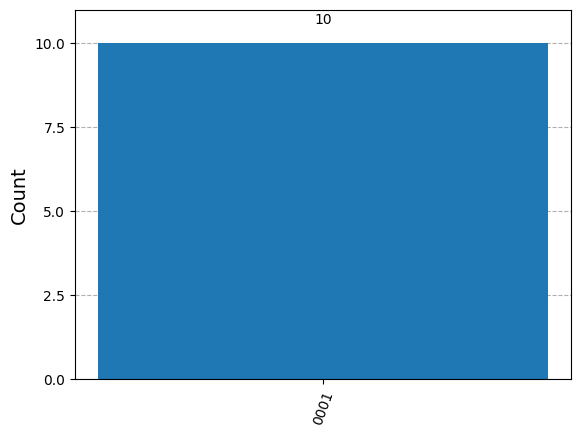

In [103]:
# Importing standard Qiskit libraries
# from qiskit import transpile
# from qiskit.circuit.library import RealAmplitudes
# from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer, AerSimulator
# from qiskit_aer.primitives import SamplerV2

from qiskit.visualization import *
import matplotlib as mpl
from qiskit.circuit.library import SwapGate
from math import *

from qiskit_aer import AerSimulator

circuit = BuildModExpCircuit(7, 2, 15)
simulator = Aer.get_backend("qasm_simulator")
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=10)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

$\newcommand{\if}[1]{{\textbf{if }{#1}\textbf{ then:}}}$
$\newcommand{\else}{{\textbf{else:}}}$

## Continued Fractions Algorithm

The Continued Fractions Algorithm finds the continued fraction expansion for any irrational number to as many partial denominators as desired

The following system of equations is a way of describing the continued fractions algorithm

$$
\begin{align*}
   x &= a_0 + b_0 \\
   \frac{1}{b_0} &= a_1' = a_1 + b_1 \\
   &\vdots\\
   \frac{1}{b_k} &= a_{k+1}' = a_{k+1} + b_{k+1}
\end{align*}
$$

Source: [Cornell](https://pi.math.cornell.edu/~gautam/ContinuedFractions.pdf)

---

**Algorithm ContinuedFraction(x)**
 
**Input:** A number $x \in \mathbb{R}$

**Output:** Continued fraction representation of $x$: $\left[ a_0, a_1, a_2, ... \right]$ such that


**begin**

1. $a_m := \lfloor$ (i.e., let $a_m$ be the integer part of $x_m$)
2. $b_m := x_m - a_m$
3. $\if{b_m \neq 0}$
4. &emsp; Set $x_{m+1} = 1/b_m$ and go back to step 1 to compute $a_{m+1}$
5. $\else$
6. &emsp; return

**end.**

Note: as some sequences can grow very large, we define a positive $\epsilon \ll 1$ so that instead of directly testing $b_m = 0$, we instead test $|b_m| < \epsilon$. This will allow us to check if $b_m$ is approximately zero.

---

In [30]:
import numpy as np

def ContinuedFraction(x, eps=1e-8, retlist=False):
    """
    Return approximate fraction representation of a value.

    Parameters
    ----------
        eps : int, optional
            The threshold for approximating bm to 0. Default: 1e-8.
        retlist : bool, optional
            if True, also returns the list of coefficients for the representation.

    Returns
    -------
        numr: int
            The numerator of the approximated fraction.
        denr: int
            Only returned is `retlist` is False
            
            The denominator of the approximated fraction.
        coeffs: ndarray
            Only returned if `retlist` is True

            Coefficient representation of the approximated fraction.
    """
    
    def BuildContinuedFractionRepresentation(xm, a: np.ndarray):
        # Compute the integer part of xm
        am = int(xm)                      
        
        # Add integer part of xm to the results list (denominator of continued fractions)                                
        a = np.append(a, am)
        
        # Compute denominator of x_{m+1}                                  
        bm = xm - am                                                      
        
        # Terminate if bm ~ 0 
        if np.abs(bm) < eps:
            return a
        else:
            # Compute a_{m+1}
            return BuildContinuedFractionRepresentation(1/bm, a)

    # Get coefficients of approximated fraction 
    coeffs = BuildContinuedFractionRepresentation(x, np.array([], dtype=int))

    # https://math.stackexchange.com/questions/3084970/how-to-convert-continued-fractions-into-normal-fractions
    H = np.empty(len(coeffs) + 2)
    K = np.empty_like(H)
    H[0], H[1] = 0, 1
    K[0], K[1] = 1, 0
    for n in range(2, len(H)):
        H[n] = coeffs[n-2] * H[n-1] + H[n-2]
        K[n] = coeffs[n-2] * K[n-1] + K[n-2]

    numr = H[-1]
    denr = K[-1]

    if retlist:
        return numr, denr, coeffs
    
    return numr, denr

    
# =================================
# tests
# =================================

# 23/8 = 2.875
assert (ContinuedFraction(2.875) == (23, 8))
assert (ContinuedFraction(2.875, retlist=True)[2] == [2,1,7]).all()

# 27/4 = 6.75
assert (ContinuedFraction(6.75) == (27,4))
assert (ContinuedFraction(6.75, retlist=True)[2] == [6,1,3]).all()

print('All tests passed')

All tests passed


# Modular Exponentiation

This will describe how the unitary operator $U$ (to be used in the quantum period-finding subroutine) will be constructed.

---

**Algorithm QModularExponentiation**

**Input:** 
- Integers $a,N$: same values from **Algorithm Shor**
- Integer $x$
- Integers $n,m$: the number of qubits being used in each register

**Output:** Operator $U$ such that 

$$
U\left( \frac{1}{\sqrt{2^{n}}} \sum_{x \in \{ 0,1 \}^{n}} \ket{x} \ket{1}^{\otimes m} \right) = \frac{1}{\sqrt{2^{n}}} \sum_{x \in \{ 0,1 \}^{n}} \ket{x} \ket{a^x \bmod{N}}^{\otimes m}
$$

**begin**

1. Convert $x$ to binary: $x = x_{n-1} x_{n-2} \dots x_{0} = x_{n-1}2^{n-1} + x_{n-2}2^{n-2} + \dots + x_{0}2^{0} = \sum_{k=0}^{n-1} x_k 2^k$

> Note that $a^x \bmod{N} = a^{\sum_{k=0}^{n-1} x_k 2^k} \bmod{N} = \left( (a^{x_{n-1}2^{n-1}}\bmod{N})(a^{x_{n-2}2^{n-2}}\bmod{N}) \dots (a^{x_0 2^0} \bmod{N})\right) \bmod{N}$

**end.**

---


Operator $V$ such that $V \ket{x} \ket{y} = \ket{x} \ket{xy \bmod{N}}$

In [102]:
import math
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import MultiplierGate

def NumBitsRequired(n: int) -> int:
    return int( math.log(n,2) + 1 ) if n > 0 else 0


def IntToBitList(n: int, num_bits: int = None) -> list:
    nbits = NumBitsRequired(n)
    if num_bits != None: nbits = num_bits

    return [(n >> bit) & 1 for bit in range(nbits - 1, -1, -1)]


def c_mod_mult(qc, target_register, copy_register, bit_register, ctrl_qubit, a, N):
    """
    Appends to the quantum circuit qc the operation |y⟩ -> |a*y mod N⟩ (y ~ target_register)
    controlled by ctrl_qubit.
    """

    # input registers must be same size
    m = len(target_register)
    if m != len(copy_register) or m != len(bit_register):
        print('registers are of different sizes')
        raise ValueError(f'Registers are of different sizes ({len(target_register)}, {len(copy_register)}, {len(bit_register)})')
    
    a_bits = IntToBitList(a, m)

    # initialize bit_register
    # since each qbit in bit_register is initialized to |0⟩
    #     we simply flip each qbit so that it is equivalent to `a`
    for i,bit in enumerate(a_bits):
        if bit == 1:
            qc.x(bit_register[i])

    # since copy_register is initialized to |0⟩
    #     doing a CX with target_register as control will result in
    #     copy_register being a 'copy' of target_register
    qc.cx(target_register, copy_register)

    mult_gate = MultiplierGate(m,m,label=f'* {a}^({ctrl_qubit._register.name}_{ctrl_qubit._index} * 2^{len(ctrl_qubit._register) - ctrl_qubit._index - 1})')
    qc.append(mult_gate, bit_register[:] + copy_register[:] + target_register[:])

    # multiplication is done - now uncompute ancillas
    for i,bit in enumerate(a_bits):
        if bit == 1:
            qc.x(bit_register[i])
    
    return


def c_amodN(qc: QuantumCircuit, qr1, qr2, ar1, ar2, a: int, N: int, x: int = 1, wrap = True):
    """
    Returns a quantum gate/circuit that implements |x⟩|y⟩ -> |x⟩|a^x mod N⟩
    """
    print(f'Running c_amodN with a = {a}, x = {x}, N = {N}')

    n = len(qr1)
    m = len(qr2)

    for i in range(n):
        exponent = 2**i
        a_exp = pow(a, exponent, N) # = (a^exponent) mod N

        ctrl_q = qr1[i]
        c_mod_mult(qc, qr2, ar1, ar2, ctrl_q, a_exp, N)

        return
    
    return

In [103]:
from qiskit.circuit.library import QFT
from qiskit import ClassicalRegister, QuantumRegister

def funclog(msg: str, debug):
    if debug: print(msg)

def BuildPeriodFindingCircuit(a, N, eps=1e-1, debug=True):
    L =  NumBitsRequired(N) # number of bits needed to represent N
    # m = L + math.ceil( math.log(2 + 1/2/eps, 2) )
    m = L
    n = 2*m
    
    funclog(f'n={n}, m={m}', debug)

    qr1 = QuantumRegister(n, name='x')
    qr2 = QuantumRegister(m, name='ψ')
    ar1 = AncillaRegister(m, name='copy')
    ar2 = AncillaRegister(m, name='a_bits')
    # Classical register for storing measurements
    crr = ClassicalRegister(n, name='clr')

    # Create circuit and initialize second register to |1⟩
    circ = QuantumCircuit(qr1, qr2, ar1, ar2, crr)
    circ.x(qr2[-1])
    funclog('initialized circuit', debug)

    # apply Hadamard gate to first register
    funclog('applying Hadamard...', debug)
    circ.h(qr1)
    circ.barrier()

    
    # apply the Unitary operator to second register
    # --------------------------------------------------------
    funclog('applying U...', debug)
  
    # modexp_circ = c_amodN(a, N, m)
    # circ = circ.compose(modexp_circ)
    c_amodN(circ, qr1, qr2, ar1, ar2, a, N, m, wrap=False)
        
    # --------------------------------------------------------
    circ.barrier()

    #Apply inverse QFT to the first Register
    funclog('applying IQFT...', debug)
    circ.append(QFT(n, inverse=True), qr1)
    circ.barrier()
    
    #Measure the first register 
    funclog('measuring...', debug)
    circ.measure(qr1, crr)
    
    return circ, n, m

In [104]:
a, N = 7, 15

circ, n, m = BuildPeriodFindingCircuit(a, N)

#Execute the ciruit 
circ.draw(fold=-1)

n=8, m=4
initialized circuit
applying Hadamard...
applying U...
Running c_amodN with a = 7, x = 4, N = 15
applying IQFT...
measuring...


┌───┐ ░                                                ░ ┌───────┐ ░ ┌─┐                     
     x_0: ┤ H ├─░────────────────────────────────────────────────░─┤0      ├─░─┤M├─────────────────────
          ├───┤ ░                                                ░ │       │ ░ └╥┘┌─┐                  
     x_1: ┤ H ├─░────────────────────────────────────────────────░─┤1      ├─░──╫─┤M├──────────────────
          ├───┤ ░                                                ░ │       │ ░  ║ └╥┘┌─┐               
     x_2: ┤ H ├─░────────────────────────────────────────────────░─┤2      ├─░──╫──╫─┤M├───────────────
          ├───┤ ░                                                ░ │       │ ░  ║  ║ └╥┘┌─┐            
     x_3: ┤ H ├─░────────────────────────────────────────────────░─┤3      ├─░──╫──╫──╫─┤M├────────────
          ├───┤ ░                                                ░ │  IQFT │ ░  ║  ║  ║ └╥┘┌─┐         
     x_4: ┤ H ├─░────────────────────────────────────────────────░─┤4      ├─░──╫──╫──╫──╫─┤M├─────────
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║ └╥┘┌─┐      
     x_5: ┤ H ├─░────────────────────────────────────────────────░─┤5      ├─░──╫──╫──╫──╫──╫─┤M├──────
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
     x_6: ┤ H ├─░────────────────────────────────────────────────░─┤6      ├─░──╫──╫──╫──╫──╫──╫─┤M├───
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
     x_7: ┤ H ├─░────────────────────────────────────────────────░─┤7      ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├
          └───┘ ░                     ┌───────────────────┐      ░ └───────┘ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
     ψ_0: ──────░───■─────────────────┤8                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░   │                 │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_1: ──────░───┼────■────────────┤9                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░   │    │            │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_2: ──────░───┼────┼────■───────┤10                 ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
          ┌───┐ ░   │    │    │       │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_3: ┤ X ├─░───┼────┼────┼────■──┤11                 ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
          └───┘ ░ ┌─┴─┐  │    │    │  │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_0: ──────░─┤ X ├──┼────┼────┼──┤4                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ └───┘┌─┴─┐  │    │  │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_1: ──────░──────┤ X ├──┼────┼──┤5                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░      └───┘┌─┴─┐  │  │   * 7^(x_0 * 2^7) │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_2: ──────░───────────┤ X ├──┼──┤6                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░           └───┘┌─┴─┐│                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_3: ──────░────────────────┤ X ├┤7                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░                └───┘│                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_0: ──────░─────────────────────┤0                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ┌───┐               │                   │┌───┐ ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_1: ──────░─┤ X ├───────────────┤1                  ├┤ X ├─░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ├───┤               │                   │├───┤ ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_2: ──────░─┤ X ├───────────────┤2                  ├┤ X ├─░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ├───┤               │                   

In [72]:
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import SamplerV2

simulator = AerSimulator()
circuit = transpile(circ, simulator)

result = simulator.run(circuit, shots=10, memory=True).result()
memory = result.get_memory()
phase = int(memory[0],2)/(2**(n-1))
memory, phase, ContinuedFraction(phase)

(['00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000',
  '00000000'],
 0.0,
 (np.float64(0.0), np.float64(1.0)))